## Results logs
lr = 0.002, n_epochs = 100
- Vanilla SGD: Train Loss: 0.307766, Val Loss: 0.318624
- SGD With momentum: Train Loss: 0.260972, Val Loss: 0.261600
- AdaGrad: Train Loss: 0.463995, Val Loss: 0.476867
- RMSProp: Train Loss: 0.225299, Val Loss: 0.234874
- AdaDelta: Train Loss: 0.283700, Val Loss: 0.288864
- Adam: Train Loss: 0.226055, Val Loss: 0.214628
- AdaMax: Train Loss: 0.245517, Val Loss: 0.233146
- NAdam: Train Loss: 0.225083, Val Loss: 0.214890

### Best Adam:
lr = 0.002, n_epochs = 1000

- **Train Loss:** 0.179455
- **Val Loss:** 0.202177
- **Test Loss:** 0.16546

In [101]:
import numpy as np              # For numerical operations and array manipulations
import pandas as pd            # For data manipulation and analysis
import matplotlib.pyplot as plt  # Basic plotting library
import seaborn as sns           # Statistical data visualization
import math
np.random.seed(42)
%matplotlib inline

In [2]:
from models import MLP
from utils import mse_loss, plot_loss, train_one_epoch, create_mini_batches, train
from optim import *

## Data Analysis

In [3]:
RED_WINE_PATH = "../data/wine+quality/winequality-red.csv"
WHITE_WINE_PATH = "../data/wine+quality/winequality-white.csv"

In [5]:
df_red = pd.read_csv(RED_WINE_PATH, delimiter=";")
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
len(df_red)

1599

In [7]:
df_white = pd.read_csv(WHITE_WINE_PATH, delimiter=";")
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [8]:
len(df_white)

4898

In [9]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [10]:
df_red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [11]:
df_red.isnull().sum() # no null data

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### Distribution Analysis

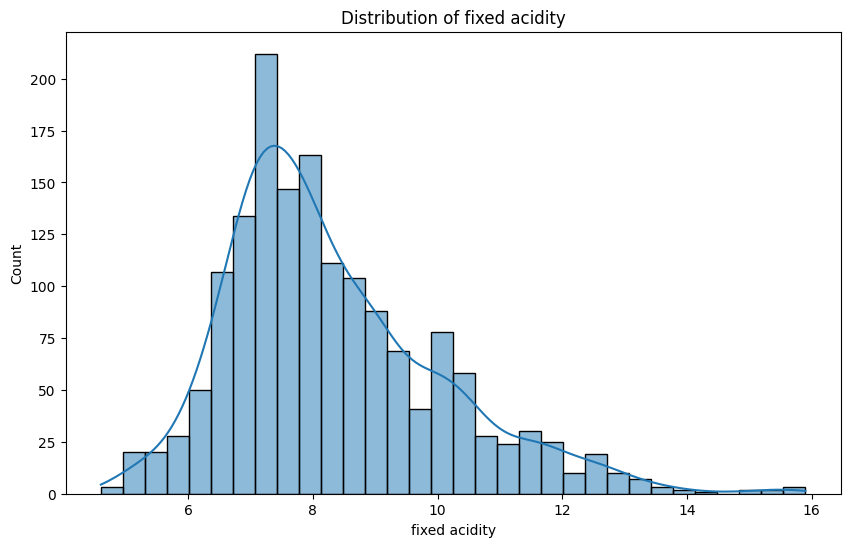

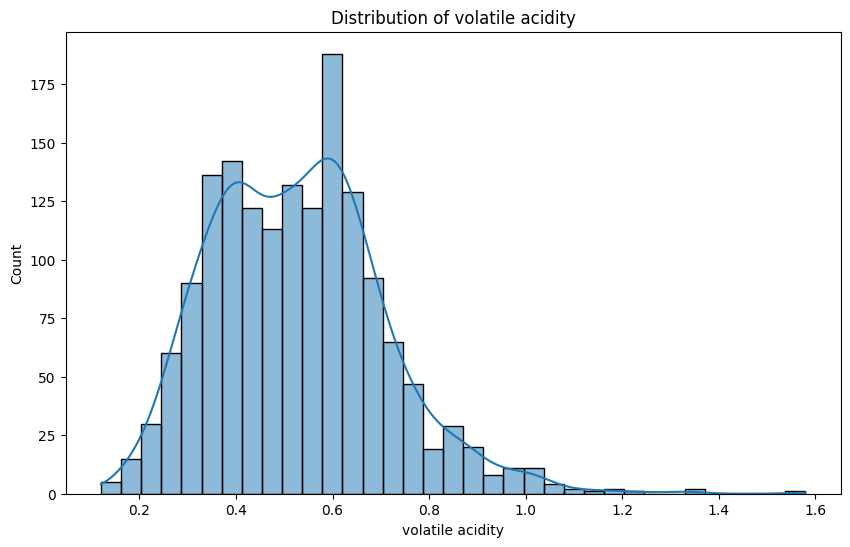

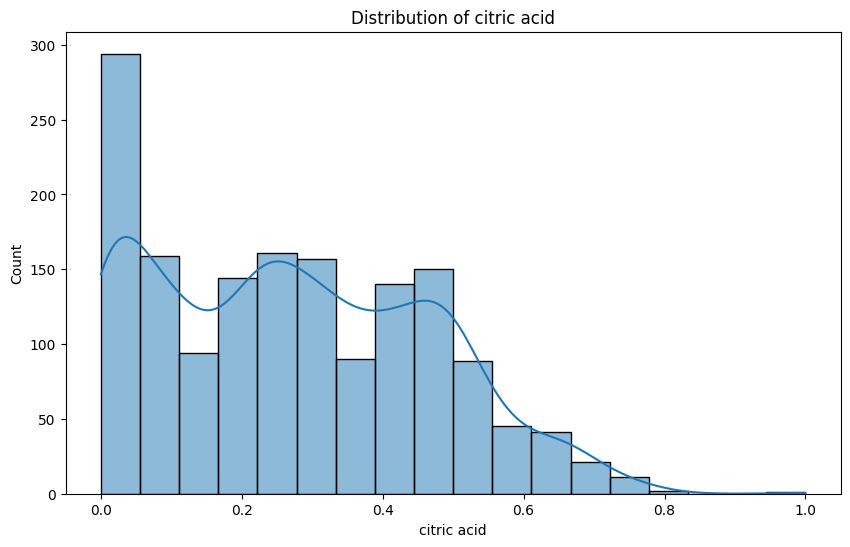

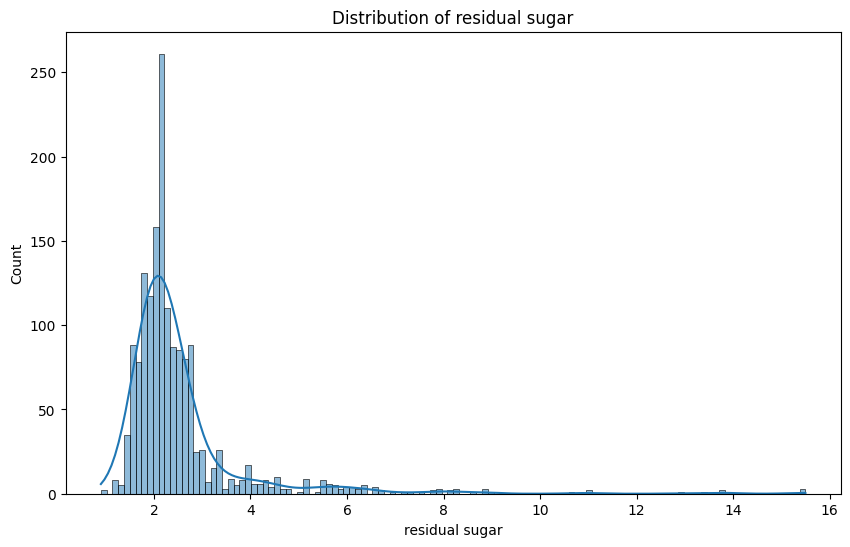

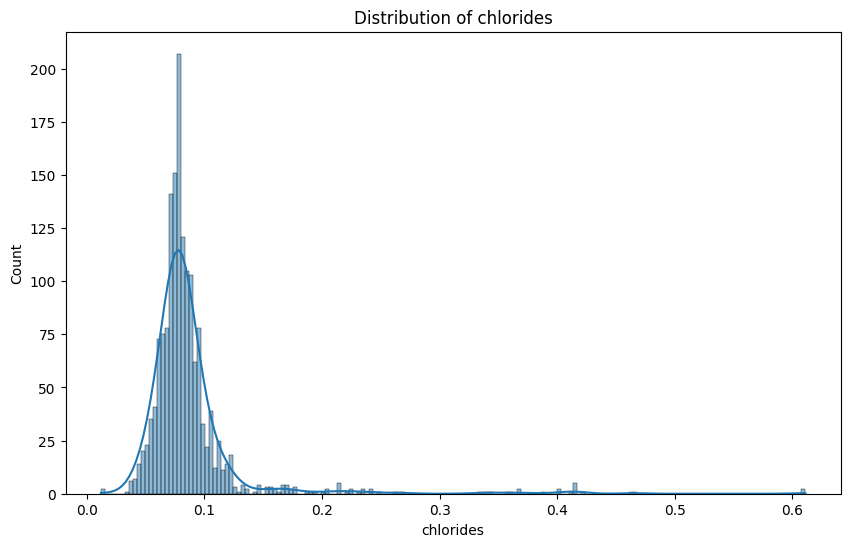

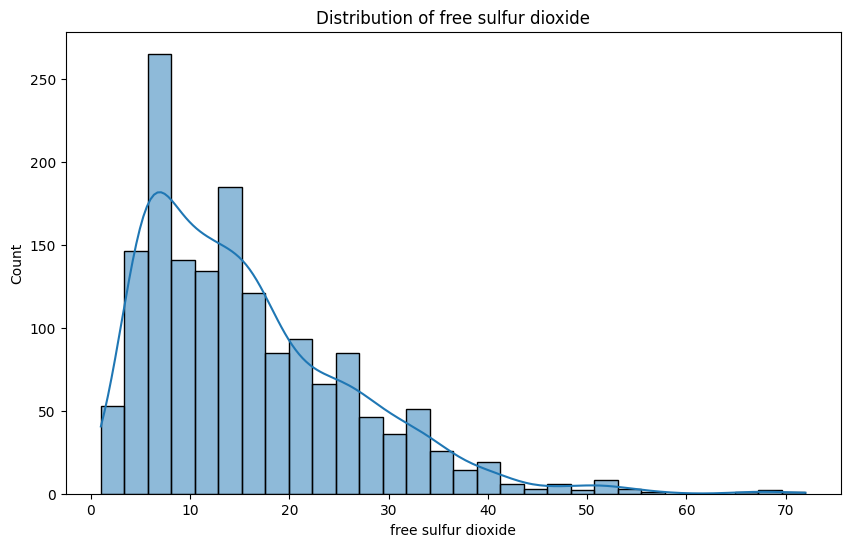

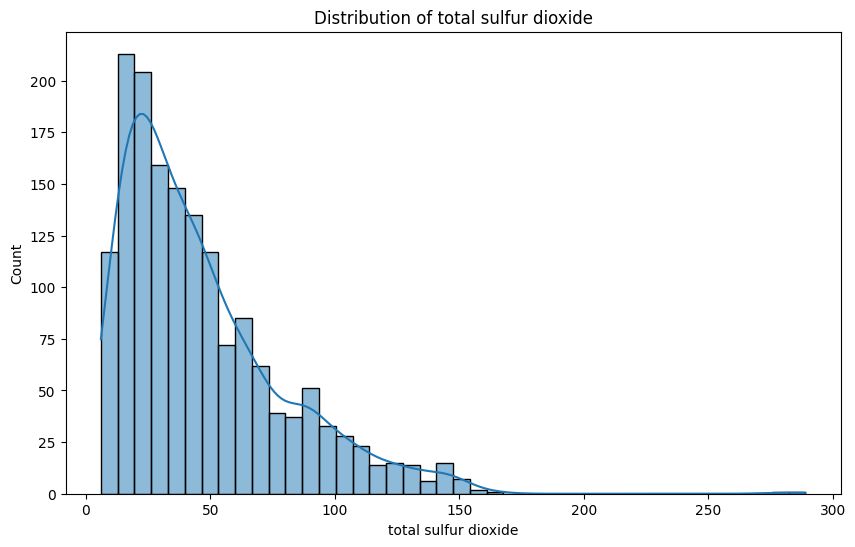

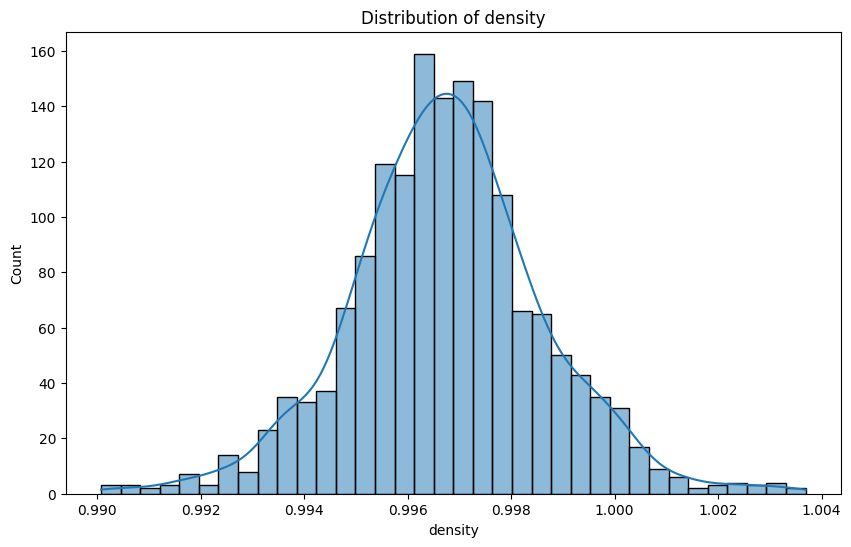

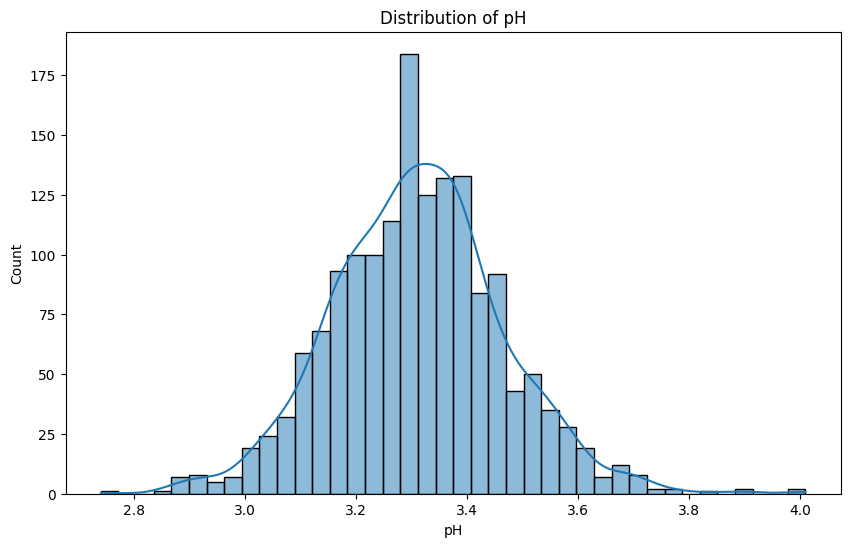

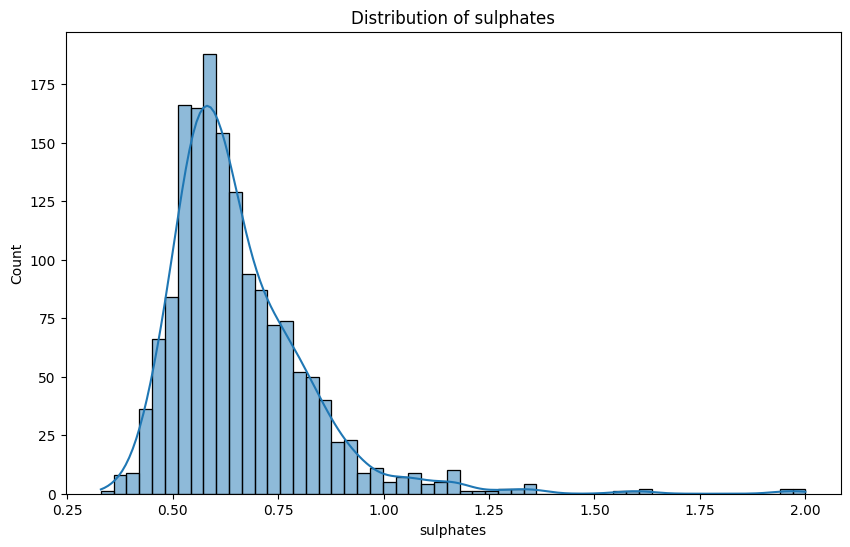

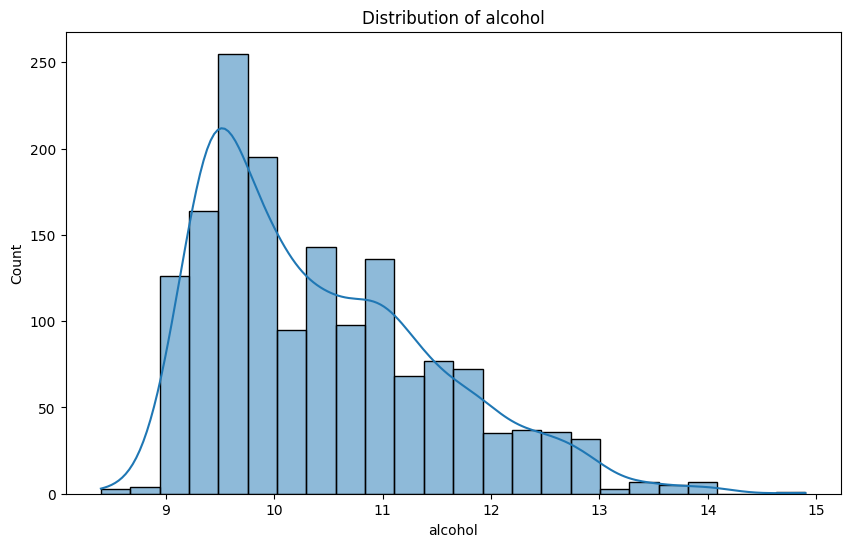

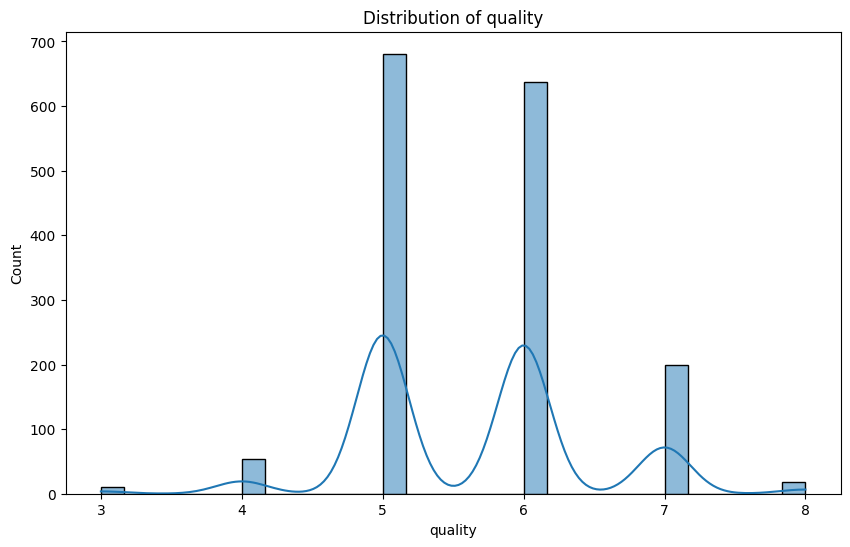

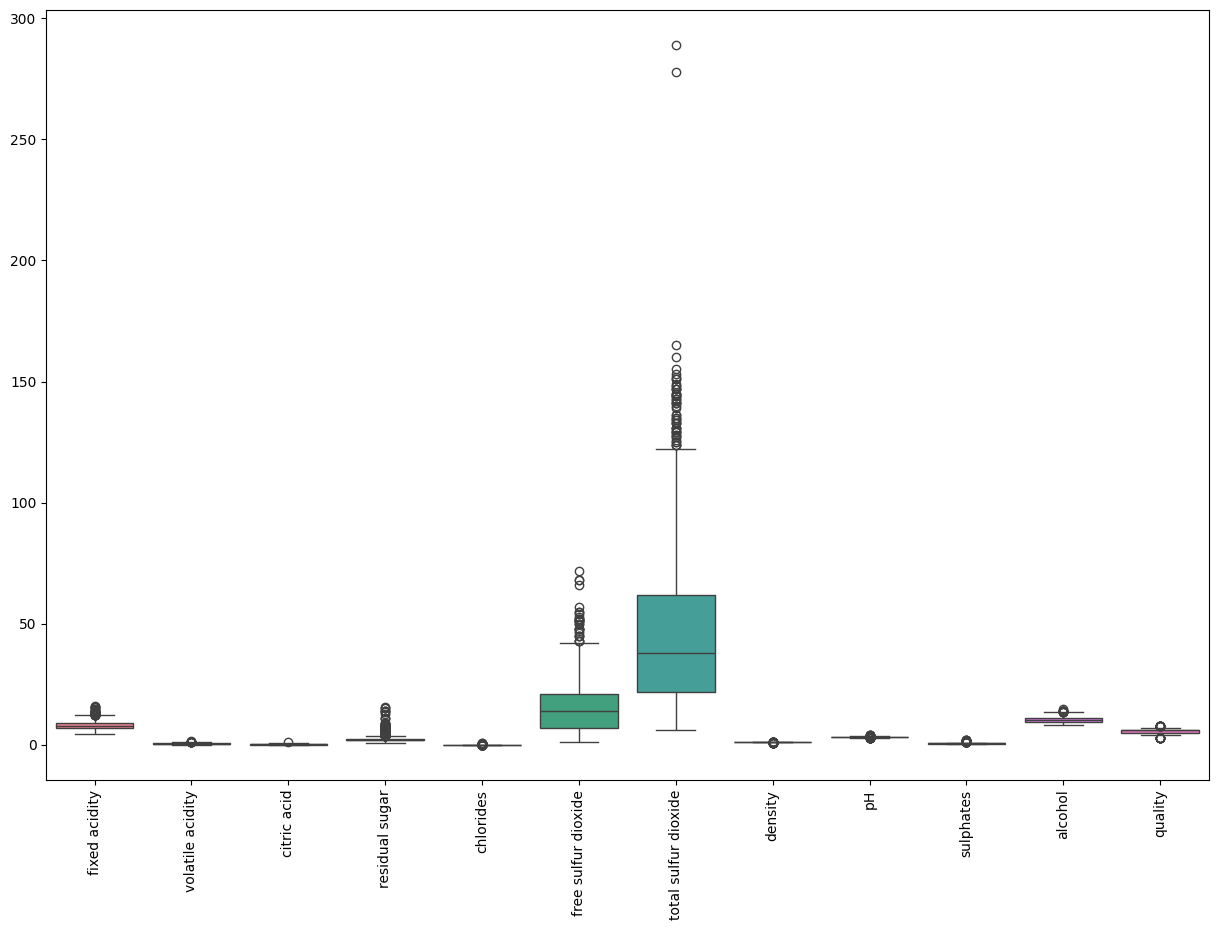

In [12]:
# Histograms for numeric features

for col in df_red.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_red[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Box plots for outlier detection
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_red.select_dtypes(include=['float64', 'int64']))
plt.xticks(rotation=90)
plt.show()

### Target analysis

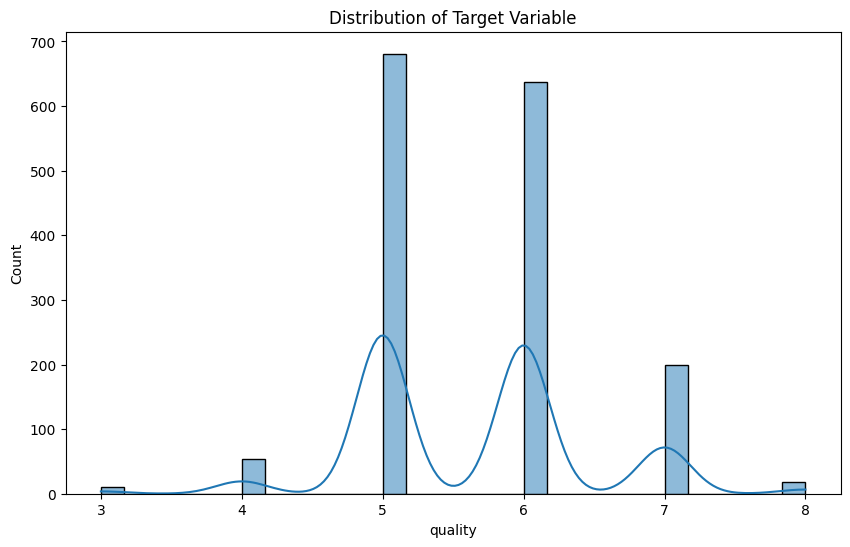

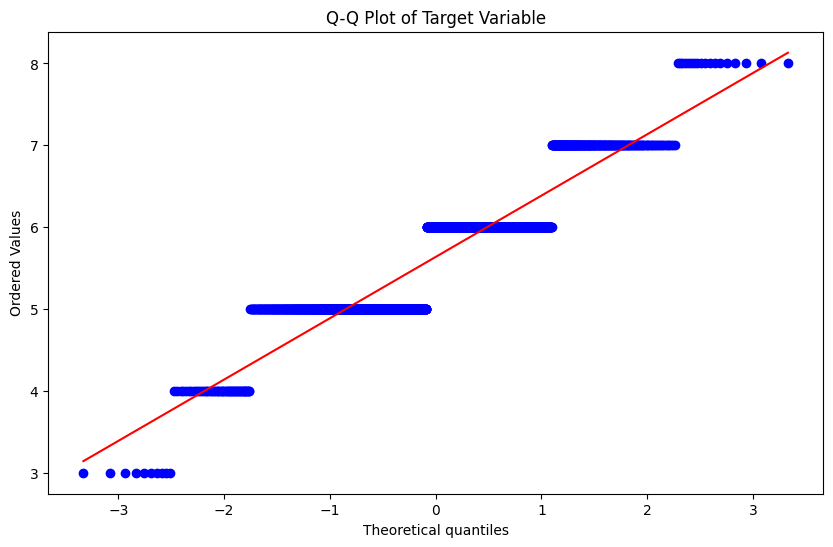

In [13]:
# Assuming 'target' is your dependent variable
plt.figure(figsize=(10, 6))
sns.histplot(df_red['quality'], kde=True)
plt.title('Distribution of Target Variable')
plt.show()

# Q-Q plot to check normality
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(df_red['quality'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Target Variable')
plt.show()

### Correlation matrix

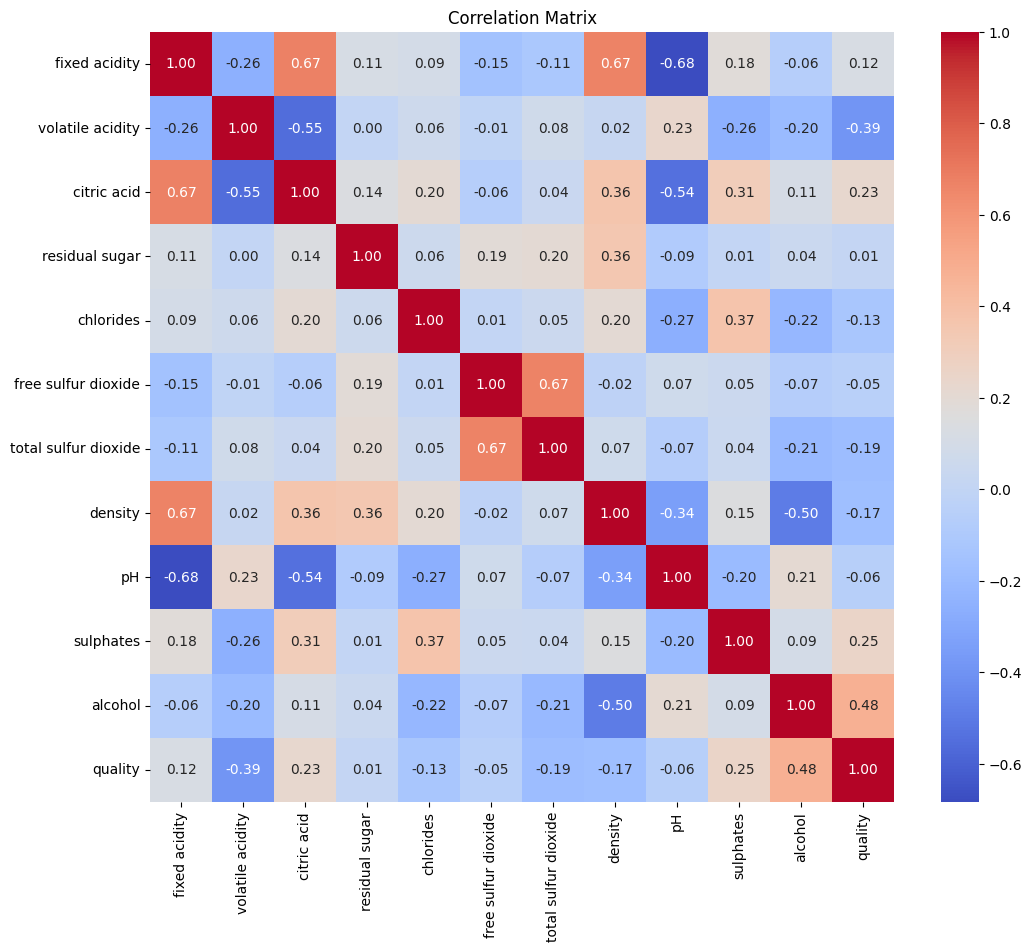

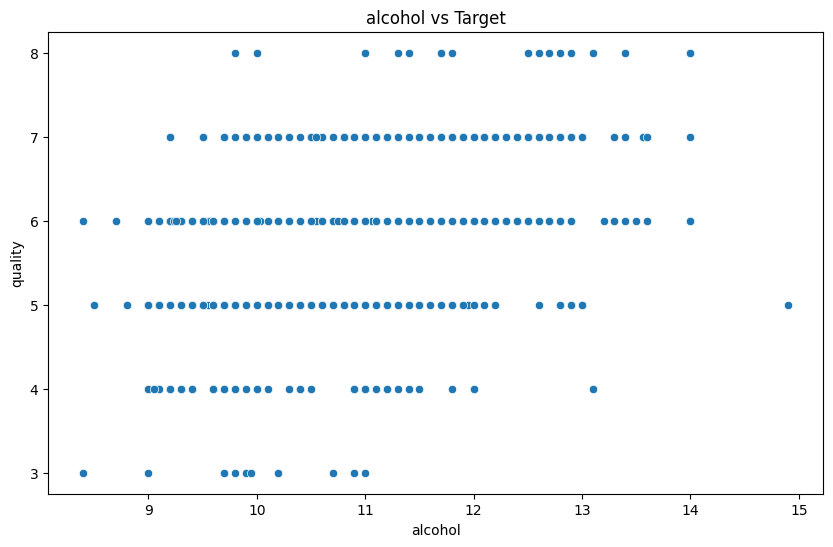

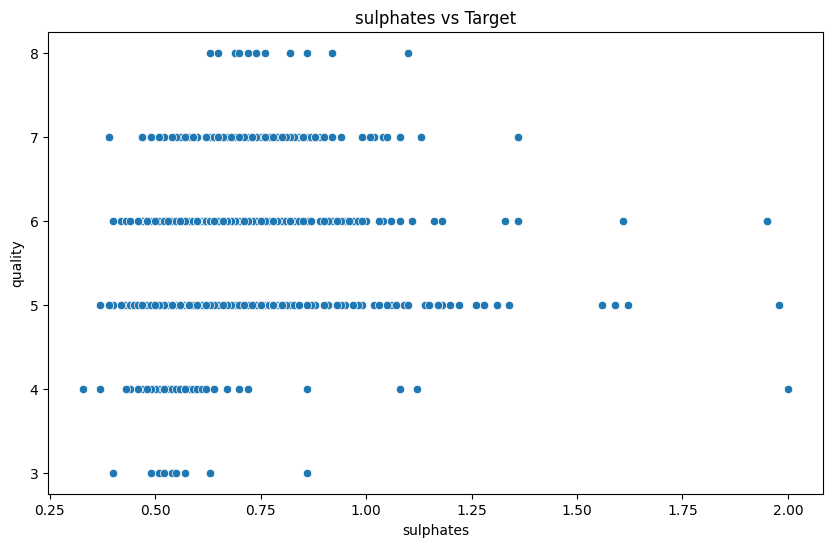

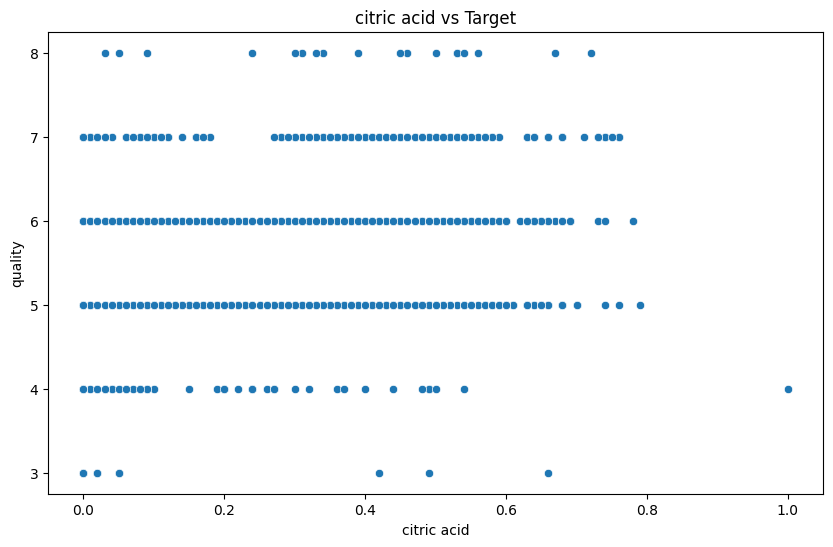

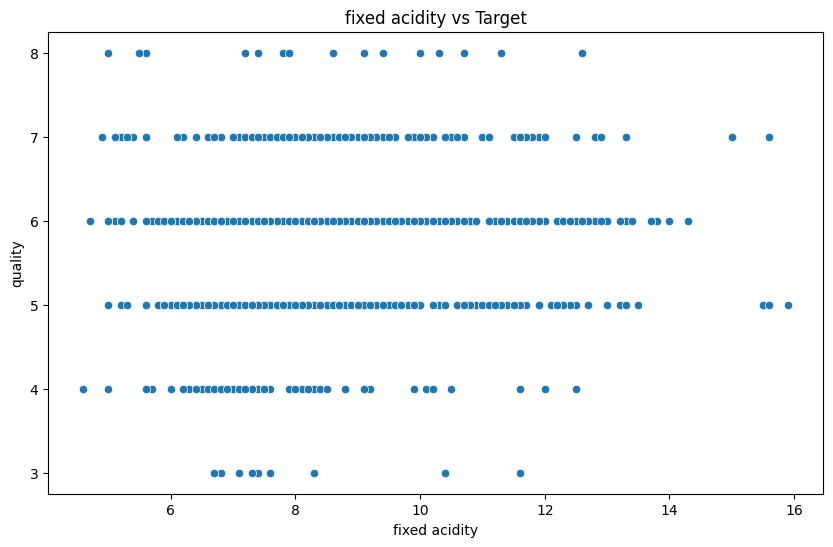

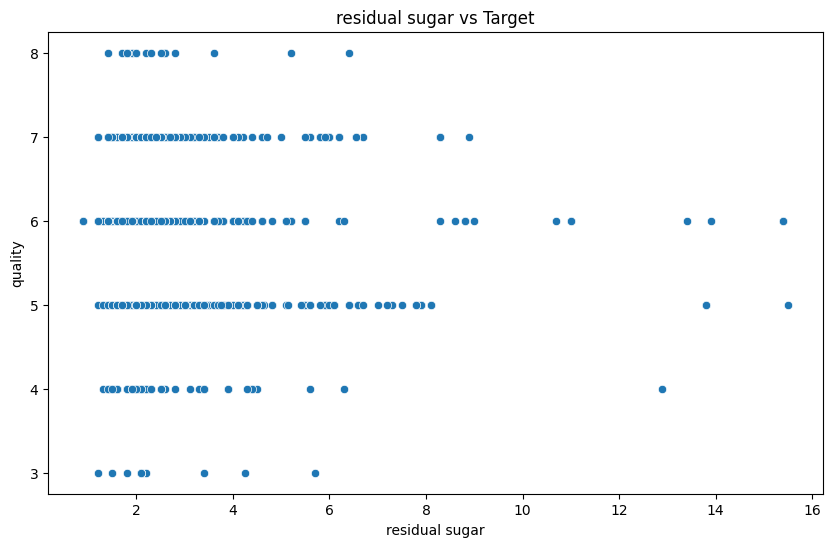

In [16]:
# Correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = df_red.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Scatter plots for top correlated features with target
top_corr_features = corr_matrix['quality'].sort_values(ascending=False).index[1:6]
for feature in top_corr_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature, y='quality', data=df_red)
    plt.title(f'{feature} vs Target')
    plt.show()

## Data Preprocessing

### Cap outlier

In [22]:
# Option: Winsorize/cap outliers
def cap_outliers(df):
    df_capped = df.copy()
    for col in df.columns:
        if col != "quality":
            q1, q99 = df[col].quantile(0.01), df[col].quantile(0.99)
            print(col, )
            df_capped[col] = df_capped[col].clip(lower=q1, upper=q99)
    return df_capped

In [26]:
df_red_capped = cap_outliers(df_red)

fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol


In [27]:
len(df_red_capped)

1599

### Log transform skewed features

In [28]:
# Check skewness
skewed_features = ['total sulfur dioxide', 'free sulfur dioxide', 'residual sugar']
for feature in skewed_features:
    df_red_capped[f'{feature}_log'] = np.log1p(df_red_capped[feature])  # log(1+x) avoids log(0) issues

In [29]:
df_red_capped.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'total sulfur dioxide_log',
       'free sulfur dioxide_log', 'residual sugar_log'],
      dtype='object')

In [33]:
features = ['fixed acidity', 'volatile acidity', 'citric acid',
       'chlorides', 'density',
       'pH', 'sulphates', 'alcohol', 'total sulfur dioxide_log',
       'free sulfur dioxide_log', 'residual sugar_log']
X = np.array(df_red_capped[features])
y = np.array(df_red_capped["quality"])

In [34]:
X.shape

(1599, 11)

In [35]:
y.shape

(1599,)

### Train-Val-Test split

In [36]:
from sklearn.model_selection import train_test_split

# First split: 80% train, 20% temp (which will be further split)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: Split the temp set into validation and test (50% each of the 20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Verify the split proportions
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X):.1%})")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X):.1%})")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X):.1%})")

Training set: 1279 samples (80.0%)
Validation set: 160 samples (10.0%)
Test set: 160 samples (10.0%)


### Scale the features

In [37]:
from sklearn.preprocessing import StandardScaler

# Standard scaling (z-score normalization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [40]:
X_test_scaled.dtype

dtype('float64')

In [43]:
X_train_scaled.shape

(1279, 11)

In [44]:
y_val

array([7, 5, 7, 6, 6, 6, 6, 6, 6, 6, 7, 5, 6, 6, 5, 6, 7, 6, 5, 5, 7, 6,
       6, 5, 5, 5, 6, 8, 6, 5, 7, 5, 6, 6, 5, 5, 5, 4, 5, 5, 7, 6, 6, 7,
       6, 6, 5, 8, 5, 6, 5, 7, 5, 5, 7, 5, 7, 6, 6, 5, 6, 3, 5, 5, 5, 6,
       6, 6, 6, 6, 5, 7, 6, 6, 5, 5, 7, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5,
       5, 5, 6, 5, 5, 6, 5, 6, 6, 5, 5, 5, 6, 6, 6, 6, 5, 5, 5, 5, 6, 7,
       7, 5, 6, 5, 5, 6, 6, 6, 5, 7, 4, 5, 7, 6, 6, 5, 6, 6, 7, 6, 5, 7,
       6, 6, 5, 5, 5, 5, 7, 5, 6, 7, 5, 6, 5, 6, 5, 6, 7, 6, 6, 6, 6, 4,
       5, 7, 4, 6, 5, 5])

In [60]:
np.save('../data/wine+quality/X_train_red.npy', X_train)
np.save('../data/wine+quality/y_train_red.npy', y_train)
np.save('../data/wine+quality/X_val_red.npy', X_val)
np.save('../data/wine+quality/y_val_red.npy', y_val)
np.save('../data/wine+quality/X_test_red.npy', X_test)
np.save('../data/wine+quality/y_test_red.npy', y_test)

## Now create MLP

In [3]:
X_train = np.load('../data/wine+quality/X_train_red.npy')
y_train = np.load('../data/wine+quality/y_train_red.npy')
y_train = y_train.reshape((len(y_train), 1))
X_val = np.load('../data/wine+quality/X_val_red.npy')
y_val = np.load('../data/wine+quality/y_val_red.npy')
y_val = y_val.reshape((len(y_val), 1))
X_test = np.load('../data/wine+quality/X_test_red.npy')
y_test = np.load('../data/wine+quality/y_test_red.npy')
y_test = y_test.reshape((len(y_test), 1))

In [4]:
X_train.shape

(1279, 11)

In [5]:
num_feats = X_train.shape[-1]

## All optimizers

### SGD

In [22]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=1) # for regression
model.get_params_count()

430

In [23]:
sgd_optim = SGDOptimizer(lr=0.002)

In [24]:
train_losses, val_losses = train(model, X_train, y_train, X_val, y_val, optim=sgd_optim, loss_fn=mse_loss, n_epochs=100, batch_size=128)

Epoch 10/100, Train Loss: 0.339718, Val Loss: 0.345696
Epoch 20/100, Train Loss: 0.329131, Val Loss: 0.335052
Epoch 30/100, Train Loss: 0.323290, Val Loss: 0.328984
Epoch 40/100, Train Loss: 0.318815, Val Loss: 0.324596
Epoch 50/100, Train Loss: 0.315557, Val Loss: 0.322380
Epoch 60/100, Train Loss: 0.312938, Val Loss: 0.320269
Epoch 70/100, Train Loss: 0.311136, Val Loss: 0.319637
Epoch 80/100, Train Loss: 0.309688, Val Loss: 0.319600
Epoch 90/100, Train Loss: 0.308477, Val Loss: 0.318955
Epoch 100/100, Train Loss: 0.307766, Val Loss: 0.318624


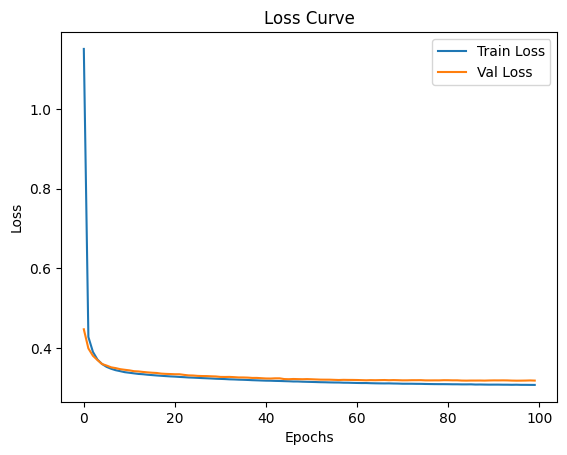

In [25]:
plot_loss(train_losses, val_losses)

### SGD with momentum

In [26]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=1) # for regression
model.get_params_count()

430

In [27]:
sgd_momentum_optim = SGDWithMomentum(lr=0.002, gamma=0.90)

In [28]:
train_losses, val_losses = train(model, X_train, y_train, X_val, y_val, optim=sgd_momentum_optim, loss_fn=mse_loss, n_epochs=100, batch_size=128)

Epoch 10/100, Train Loss: 0.312129, Val Loss: 0.311151
Epoch 20/100, Train Loss: 0.308844, Val Loss: 0.308959
Epoch 30/100, Train Loss: 0.305966, Val Loss: 0.304159
Epoch 40/100, Train Loss: 0.303827, Val Loss: 0.298058
Epoch 50/100, Train Loss: 0.300750, Val Loss: 0.296464
Epoch 60/100, Train Loss: 0.297670, Val Loss: 0.293602
Epoch 70/100, Train Loss: 0.294512, Val Loss: 0.291188
Epoch 80/100, Train Loss: 0.284195, Val Loss: 0.283350
Epoch 90/100, Train Loss: 0.267809, Val Loss: 0.274040
Epoch 100/100, Train Loss: 0.260972, Val Loss: 0.261600


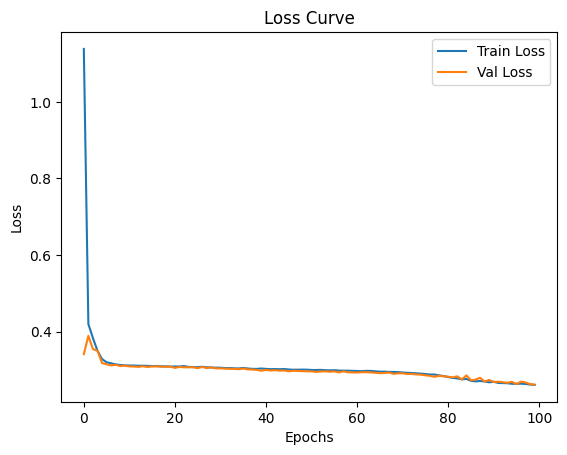

In [29]:
plot_loss(train_losses, val_losses)

### AdaGrad

In [30]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=1) # for regression
model.get_params_count()

430

In [31]:
adagrad = AdaGrad(lr=0.002, epsilon=1e-8)

In [32]:
train_losses, val_losses = train(model, X_train, y_train, X_val, y_val, optim=adagrad, loss_fn=mse_loss, n_epochs=100, batch_size=128)

Epoch 10/100, Train Loss: 0.993721, Val Loss: 0.983434
Epoch 20/100, Train Loss: 0.778470, Val Loss: 0.771992
Epoch 30/100, Train Loss: 0.702908, Val Loss: 0.695813
Epoch 40/100, Train Loss: 0.648260, Val Loss: 0.642852
Epoch 50/100, Train Loss: 0.603554, Val Loss: 0.600467
Epoch 60/100, Train Loss: 0.565245, Val Loss: 0.565206
Epoch 70/100, Train Loss: 0.532107, Val Loss: 0.535260
Epoch 80/100, Train Loss: 0.505301, Val Loss: 0.511571
Epoch 90/100, Train Loss: 0.483597, Val Loss: 0.493257
Epoch 100/100, Train Loss: 0.463995, Val Loss: 0.476867


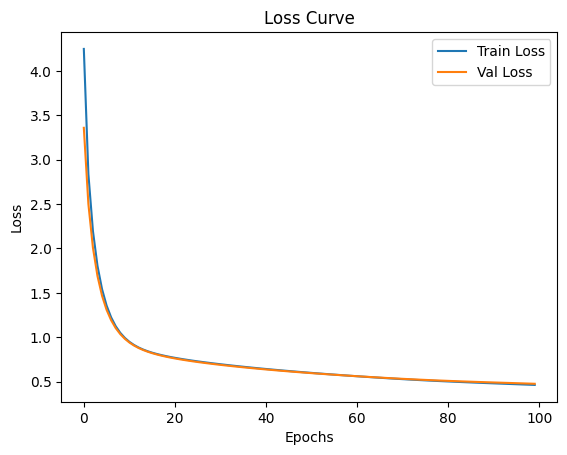

In [33]:
plot_loss(train_losses, val_losses)

### RMSProp

In [34]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=1) # for regression
model.get_params_count()

430

In [35]:
rmsprop = RMSProp(lr=0.002, epsilon=1e-8, beta=0.90)

In [36]:
train_losses, val_losses = train(model, X_train, y_train, X_val, y_val, optim=rmsprop, loss_fn=mse_loss, n_epochs=100, batch_size=128)

Epoch 10/100, Train Loss: 0.310719, Val Loss: 0.315911
Epoch 20/100, Train Loss: 0.274891, Val Loss: 0.276970
Epoch 30/100, Train Loss: 0.255991, Val Loss: 0.259443
Epoch 40/100, Train Loss: 0.246185, Val Loss: 0.261711
Epoch 50/100, Train Loss: 0.239382, Val Loss: 0.252307
Epoch 60/100, Train Loss: 0.235090, Val Loss: 0.234495
Epoch 70/100, Train Loss: 0.233134, Val Loss: 0.235934
Epoch 80/100, Train Loss: 0.232033, Val Loss: 0.242633
Epoch 90/100, Train Loss: 0.227116, Val Loss: 0.227350
Epoch 100/100, Train Loss: 0.225299, Val Loss: 0.234874


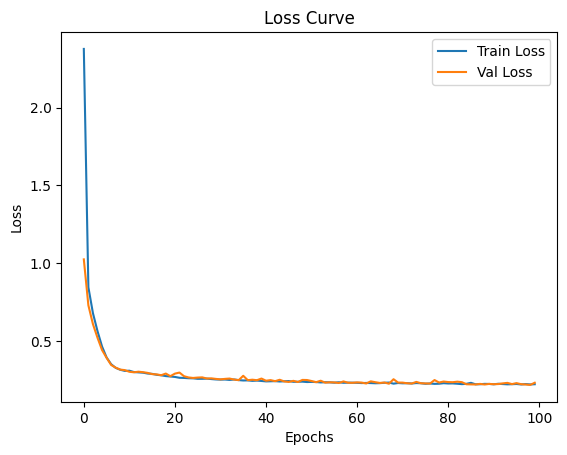

In [37]:
plot_loss(train_losses, val_losses)

### AdaDelta

In [38]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=1) # for regression
model.get_params_count()

430

In [40]:
adadelta = AdaDelta(epsilon=1e-8, beta=0.90)

In [41]:
train_losses, val_losses = train(model, X_train, y_train, X_val, y_val, optim=adadelta, loss_fn=mse_loss, n_epochs=100, batch_size=128)

Epoch 10/100, Train Loss: 1.106492, Val Loss: 1.071542
Epoch 20/100, Train Loss: 0.647164, Val Loss: 0.631990
Epoch 30/100, Train Loss: 0.423638, Val Loss: 0.433984
Epoch 40/100, Train Loss: 0.335445, Val Loss: 0.344749
Epoch 50/100, Train Loss: 0.312738, Val Loss: 0.319658
Epoch 60/100, Train Loss: 0.304458, Val Loss: 0.307893
Epoch 70/100, Train Loss: 0.299524, Val Loss: 0.302538
Epoch 80/100, Train Loss: 0.294644, Val Loss: 0.299012
Epoch 90/100, Train Loss: 0.289531, Val Loss: 0.293989
Epoch 100/100, Train Loss: 0.283700, Val Loss: 0.288864


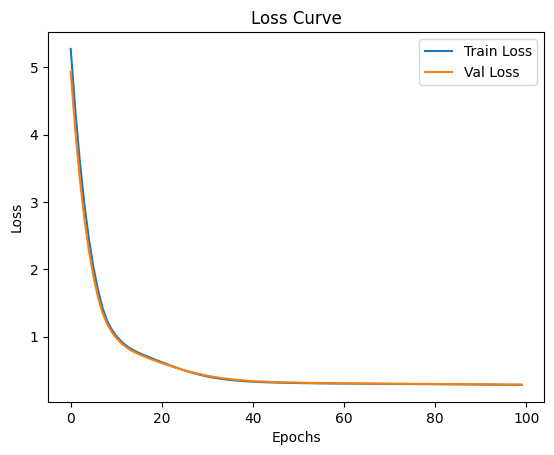

In [42]:
plot_loss(train_losses, val_losses)

### Adam

In [43]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=1) # for regression
model.get_params_count()

430

In [44]:
adam = Adam(lr=0.002, epsilon=1e-8, beta1=0.90, beta2=0.99)

In [45]:
train_losses, val_losses = train(model, X_train, y_train, X_val, y_val, optim=adam, loss_fn=mse_loss, n_epochs=100, batch_size=128)

Epoch 10/100, Train Loss: 0.392579, Val Loss: 0.420478
Epoch 20/100, Train Loss: 0.308193, Val Loss: 0.319805
Epoch 30/100, Train Loss: 0.271405, Val Loss: 0.251591
Epoch 40/100, Train Loss: 0.258250, Val Loss: 0.237102
Epoch 50/100, Train Loss: 0.248157, Val Loss: 0.234164
Epoch 60/100, Train Loss: 0.242493, Val Loss: 0.230328
Epoch 70/100, Train Loss: 0.239032, Val Loss: 0.222004
Epoch 80/100, Train Loss: 0.233033, Val Loss: 0.228156
Epoch 90/100, Train Loss: 0.228328, Val Loss: 0.222192
Epoch 100/100, Train Loss: 0.226055, Val Loss: 0.214628


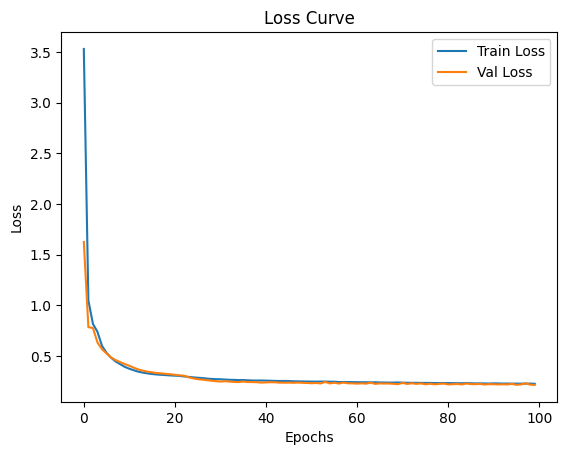

In [46]:
plot_loss(train_losses, val_losses)

### AdaMax

In [47]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=1) # for regression
model.get_params_count()

430

In [48]:
adamax = AdaMax(lr=0.002, epsilon=1e-8, beta1=0.90, beta2=0.99)

In [49]:
train_losses, val_losses = train(model, X_train, y_train, X_val, y_val, optim=adamax, loss_fn=mse_loss, n_epochs=100, batch_size=128)

Epoch 10/100, Train Loss: 0.510623, Val Loss: 0.521574
Epoch 20/100, Train Loss: 0.330365, Val Loss: 0.352262
Epoch 30/100, Train Loss: 0.301140, Val Loss: 0.309000
Epoch 40/100, Train Loss: 0.291582, Val Loss: 0.300585
Epoch 50/100, Train Loss: 0.279236, Val Loss: 0.285369
Epoch 60/100, Train Loss: 0.263636, Val Loss: 0.253926
Epoch 70/100, Train Loss: 0.258072, Val Loss: 0.249053
Epoch 80/100, Train Loss: 0.253280, Val Loss: 0.244106
Epoch 90/100, Train Loss: 0.249129, Val Loss: 0.239583
Epoch 100/100, Train Loss: 0.245517, Val Loss: 0.233146


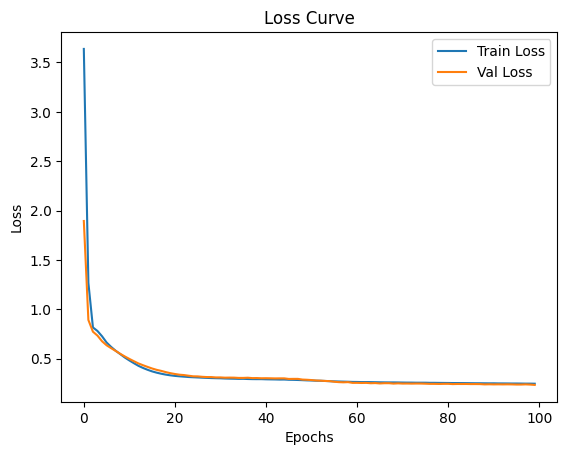

In [50]:
plot_loss(train_losses, val_losses)

### NAdam

In [51]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=1) # for regression
model.get_params_count()

430

In [52]:
nadam = NAdam(lr=0.002, epsilon=1e-8, beta1=0.90, beta2=0.99)

In [53]:
train_losses, val_losses = train(model, X_train, y_train, X_val, y_val, optim=nadam, loss_fn=mse_loss, n_epochs=100, batch_size=128)

Epoch 10/100, Train Loss: 0.378318, Val Loss: 0.403390
Epoch 20/100, Train Loss: 0.304140, Val Loss: 0.310126
Epoch 30/100, Train Loss: 0.267525, Val Loss: 0.247153
Epoch 40/100, Train Loss: 0.256137, Val Loss: 0.237535
Epoch 50/100, Train Loss: 0.247009, Val Loss: 0.235728
Epoch 60/100, Train Loss: 0.241402, Val Loss: 0.228014
Epoch 70/100, Train Loss: 0.237267, Val Loss: 0.222671
Epoch 80/100, Train Loss: 0.231967, Val Loss: 0.231173
Epoch 90/100, Train Loss: 0.227840, Val Loss: 0.223035
Epoch 100/100, Train Loss: 0.225083, Val Loss: 0.214890


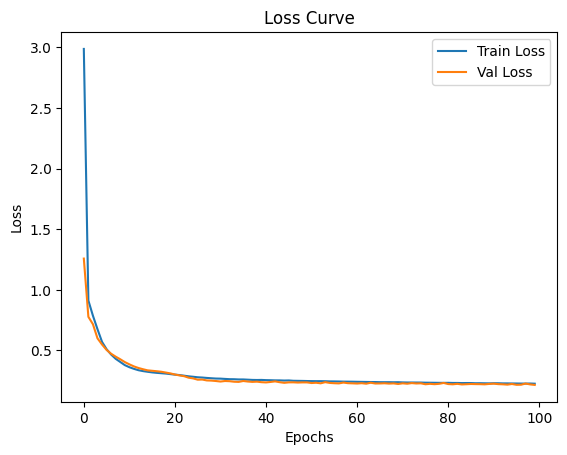

In [54]:
plot_loss(train_losses, val_losses)

## Now get the best hyperparams

Adam is the best optimizer hence seen

In [55]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=1) # for regression
model.get_params_count()

430

In [56]:
adam = Adam(lr=0.002, epsilon=1e-8, beta1=0.90, beta2=0.99)

In [57]:
train_losses, val_losses = train(model, X_train, y_train, X_val, y_val, optim=adam, loss_fn=mse_loss, n_epochs=1000, batch_size=128)

Epoch 10/1000, Train Loss: 0.392579, Val Loss: 0.420478
Epoch 20/1000, Train Loss: 0.308193, Val Loss: 0.319805
Epoch 30/1000, Train Loss: 0.271405, Val Loss: 0.251591
Epoch 40/1000, Train Loss: 0.258250, Val Loss: 0.237102
Epoch 50/1000, Train Loss: 0.248157, Val Loss: 0.234164
Epoch 60/1000, Train Loss: 0.242493, Val Loss: 0.230328
Epoch 70/1000, Train Loss: 0.239032, Val Loss: 0.222004
Epoch 80/1000, Train Loss: 0.233033, Val Loss: 0.228156
Epoch 90/1000, Train Loss: 0.228328, Val Loss: 0.222192
Epoch 100/1000, Train Loss: 0.226055, Val Loss: 0.214628
Epoch 110/1000, Train Loss: 0.223114, Val Loss: 0.220109
Epoch 120/1000, Train Loss: 0.222508, Val Loss: 0.213112
Epoch 130/1000, Train Loss: 0.219420, Val Loss: 0.220385
Epoch 140/1000, Train Loss: 0.216525, Val Loss: 0.217270
Epoch 150/1000, Train Loss: 0.214763, Val Loss: 0.215207
Epoch 160/1000, Train Loss: 0.214296, Val Loss: 0.212967
Epoch 170/1000, Train Loss: 0.213206, Val Loss: 0.214575
Epoch 180/1000, Train Loss: 0.211611, Va

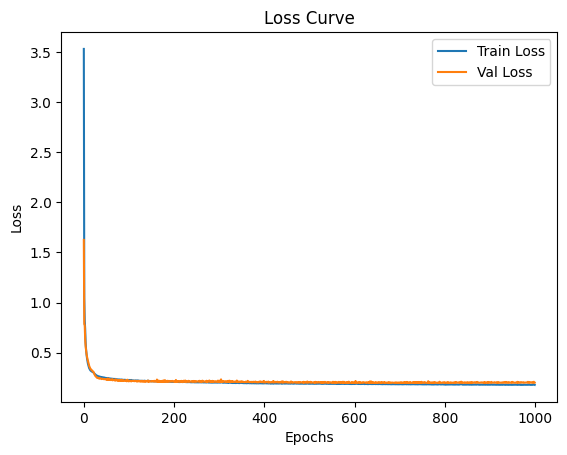

In [58]:
plot_loss(train_losses, val_losses)

In [60]:
# get the test loss
y_test_pred = model.forward(X_test)
test_loss, _ = mse_loss(y_test, y_test_pred)
print(test_loss)

0.16546414322558173


## Continue for white wine :)

In [62]:
WHITE_WINE_PATH = "../data/wine+quality/winequality-white.csv"

In [63]:
df_white = pd.read_csv(WHITE_WINE_PATH, delimiter=";")
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [64]:
df_white.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [65]:
df_white.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [66]:
df_white.isnull().sum() # no null data

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### Distribution Analysis

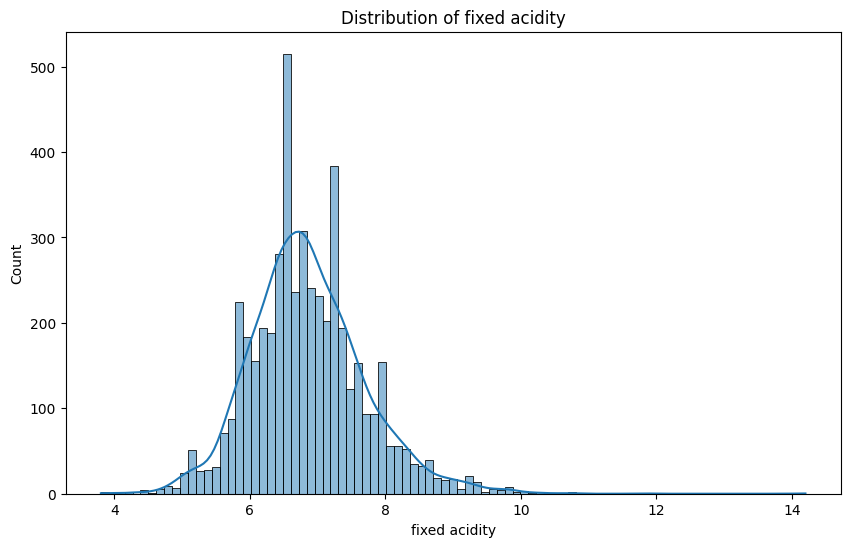

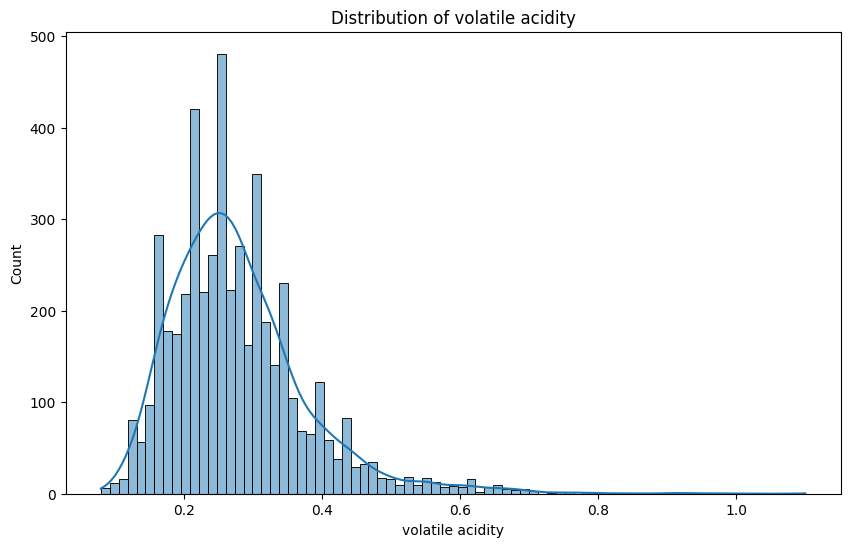

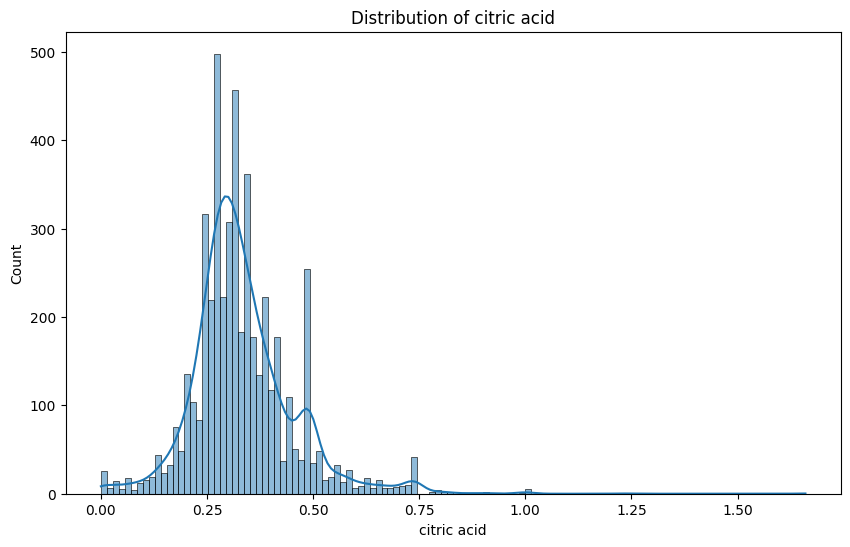

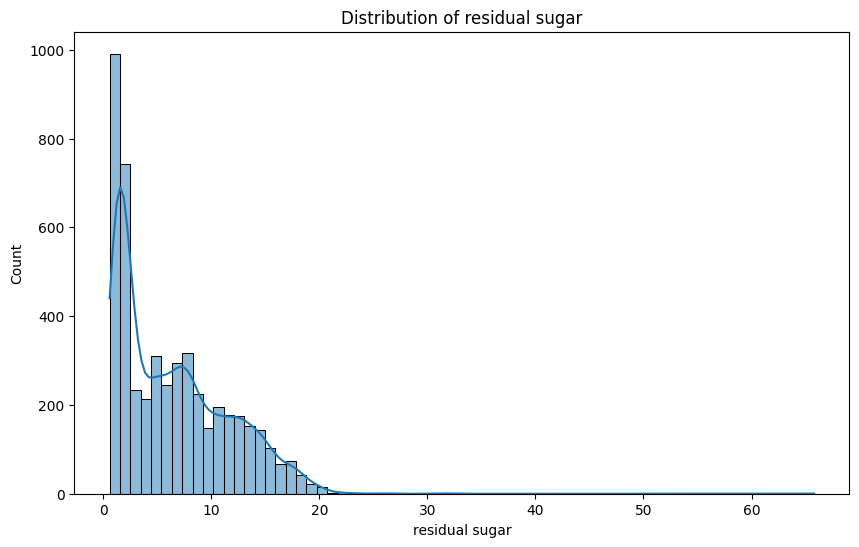

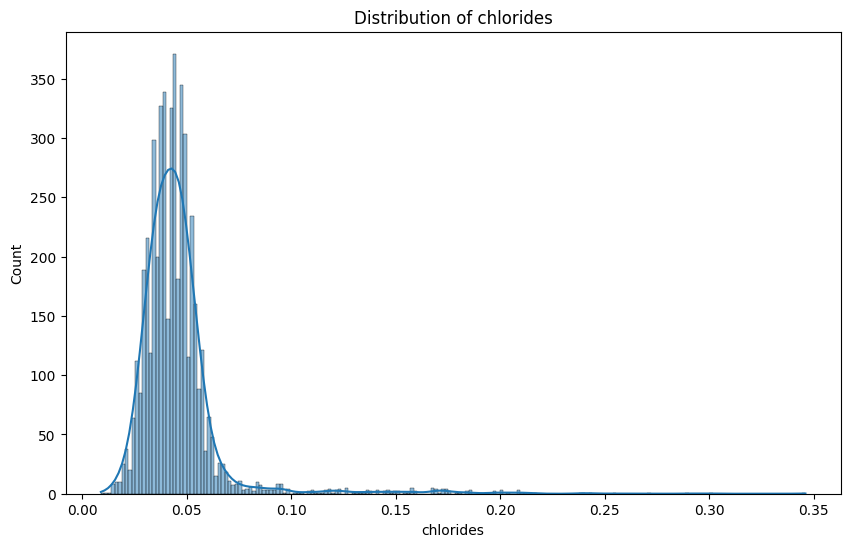

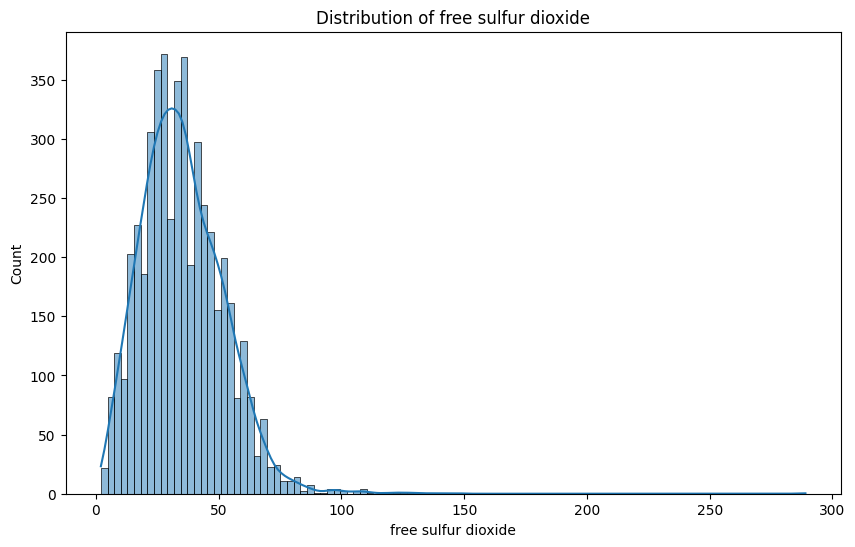

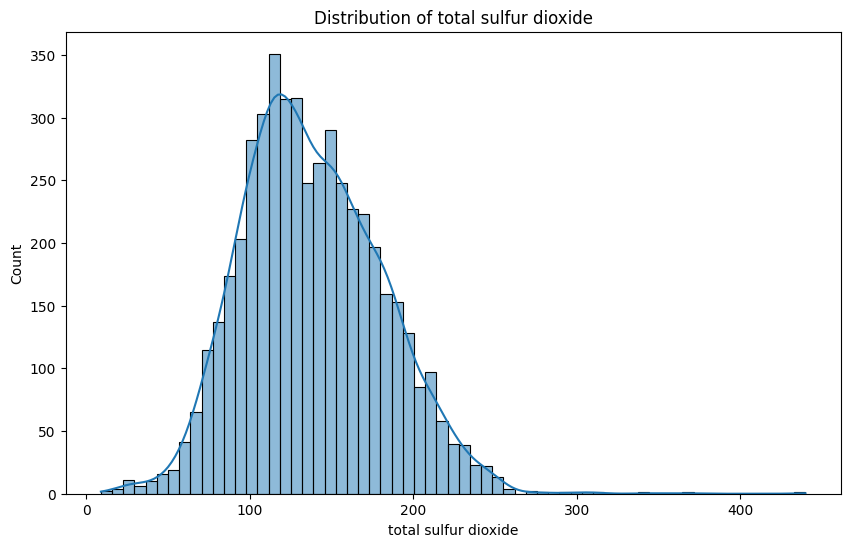

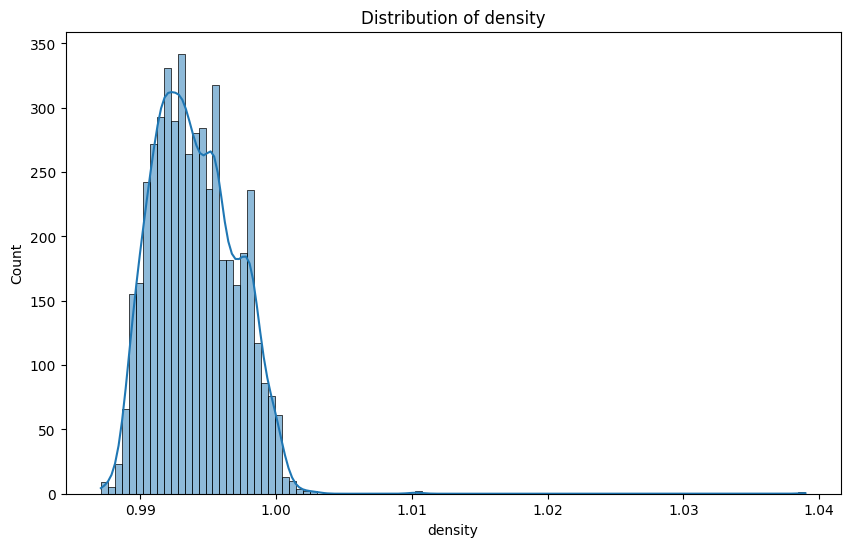

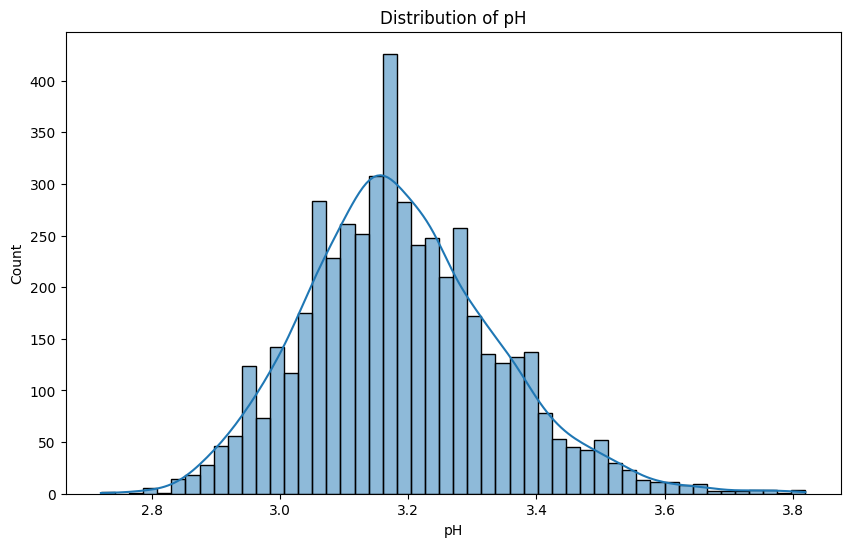

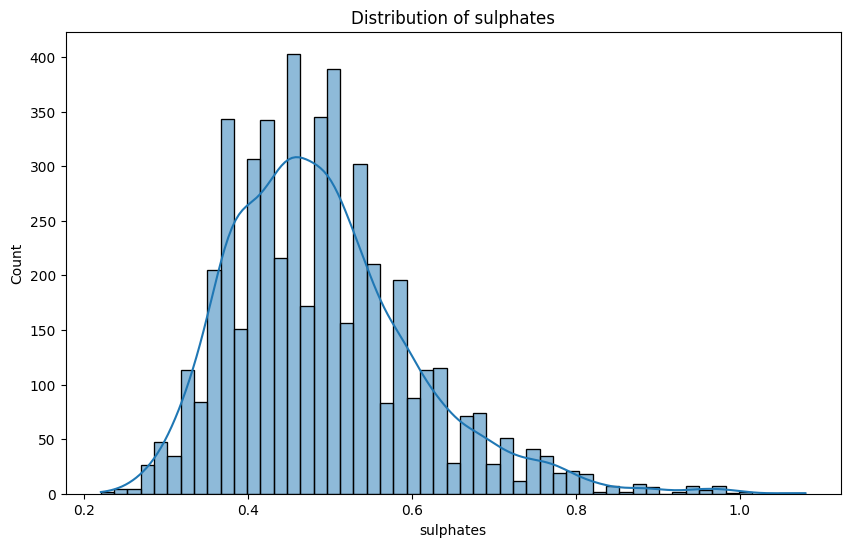

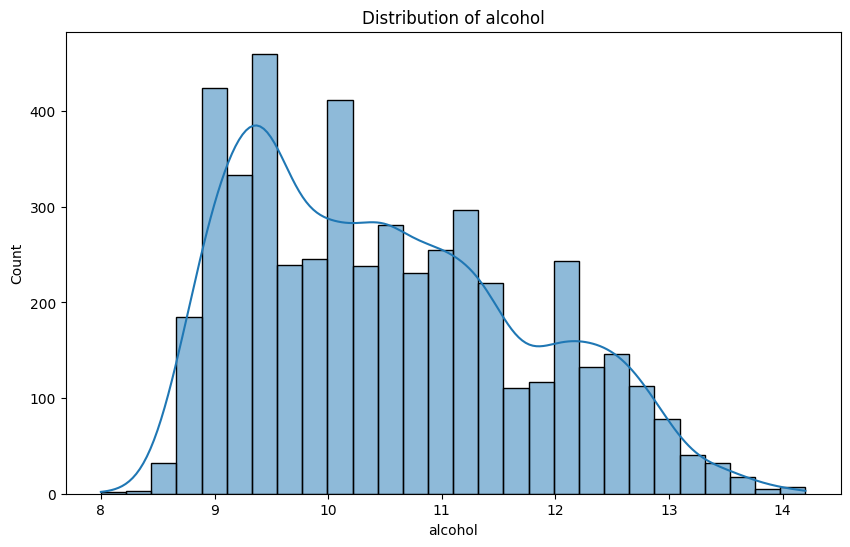

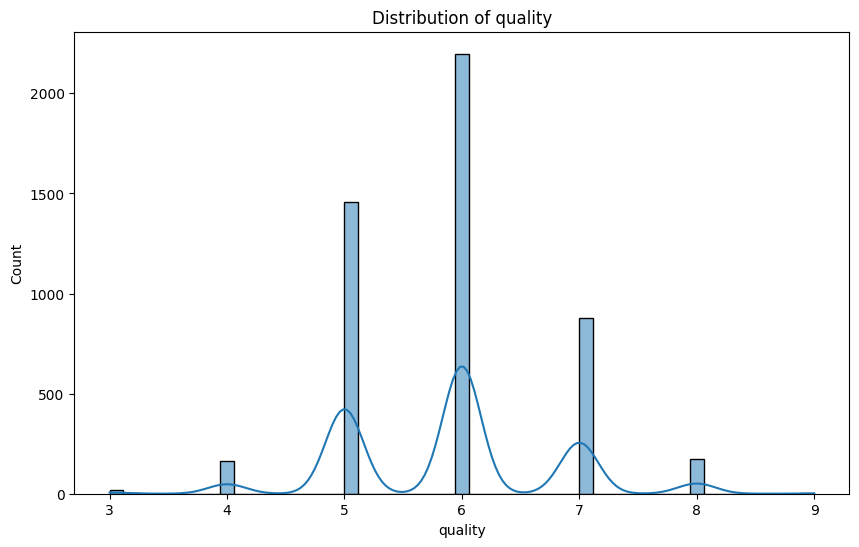

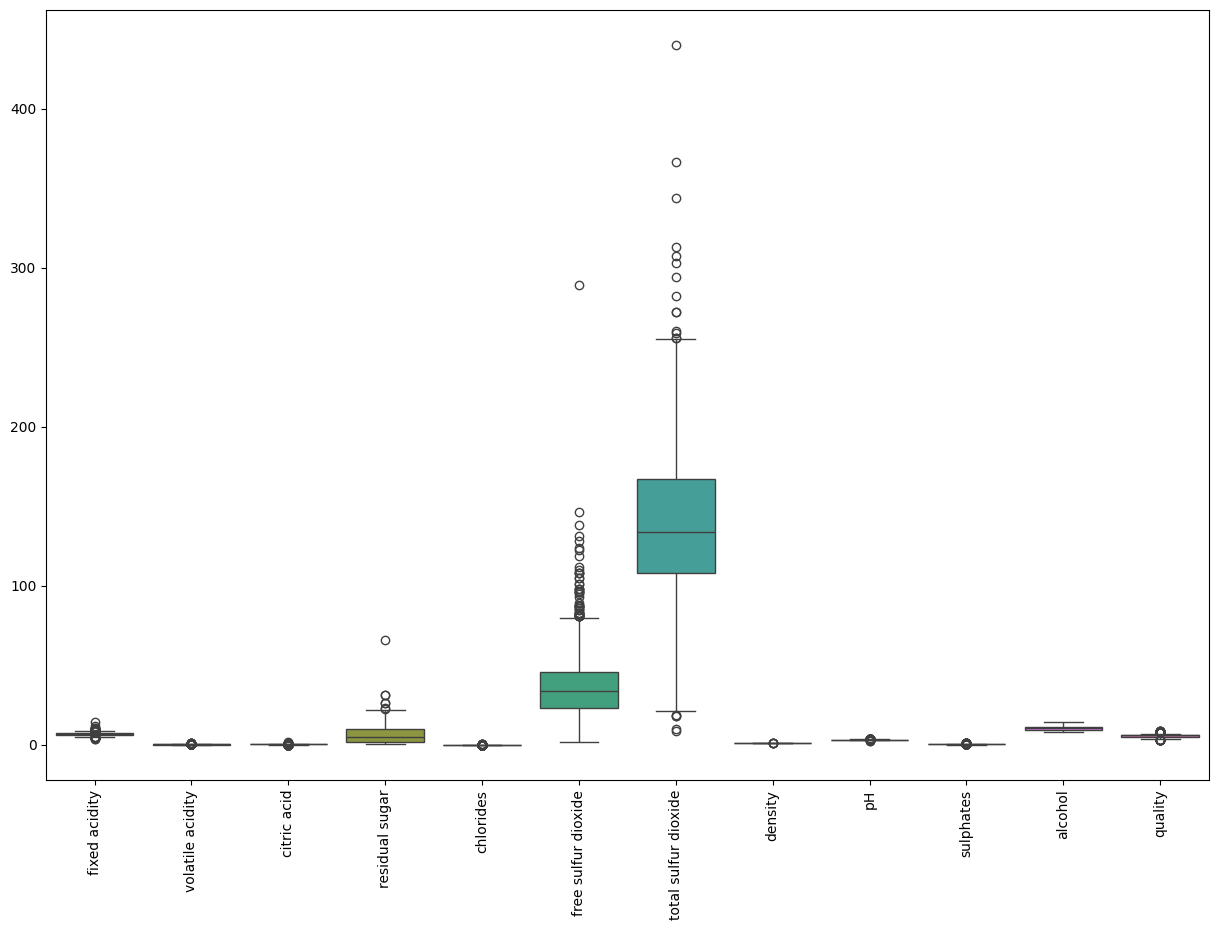

In [67]:
# Histograms for numeric features

for col in df_white.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_white[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Box plots for outlier detection
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_white.select_dtypes(include=['float64', 'int64']))
plt.xticks(rotation=90)
plt.show()

### Target analysis

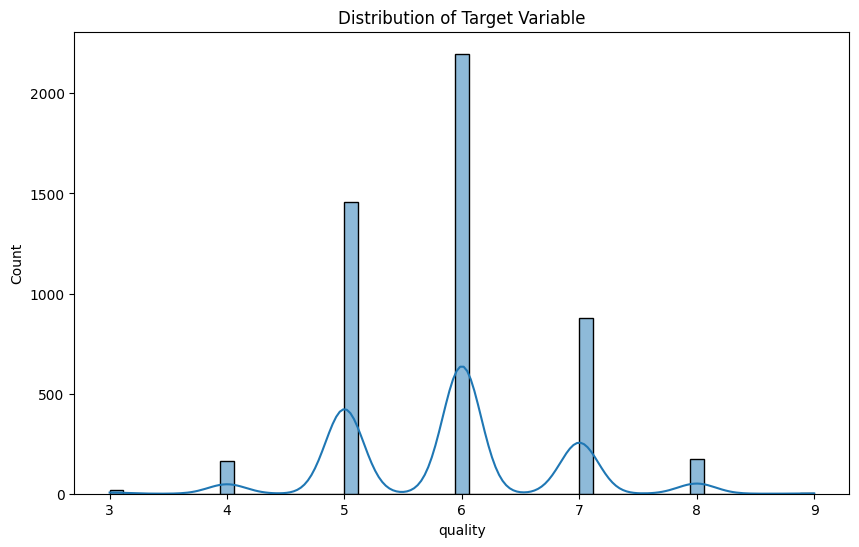

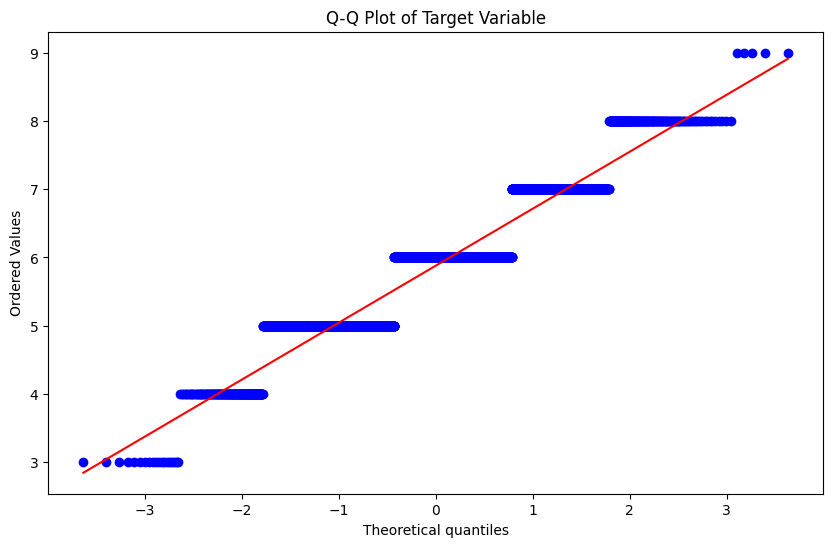

In [68]:
# Assuming 'target' is your dependent variable
plt.figure(figsize=(10, 6))
sns.histplot(df_white['quality'], kde=True)
plt.title('Distribution of Target Variable')
plt.show()

# Q-Q plot to check normality
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(df_white['quality'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Target Variable')
plt.show()

### Correlation matrix

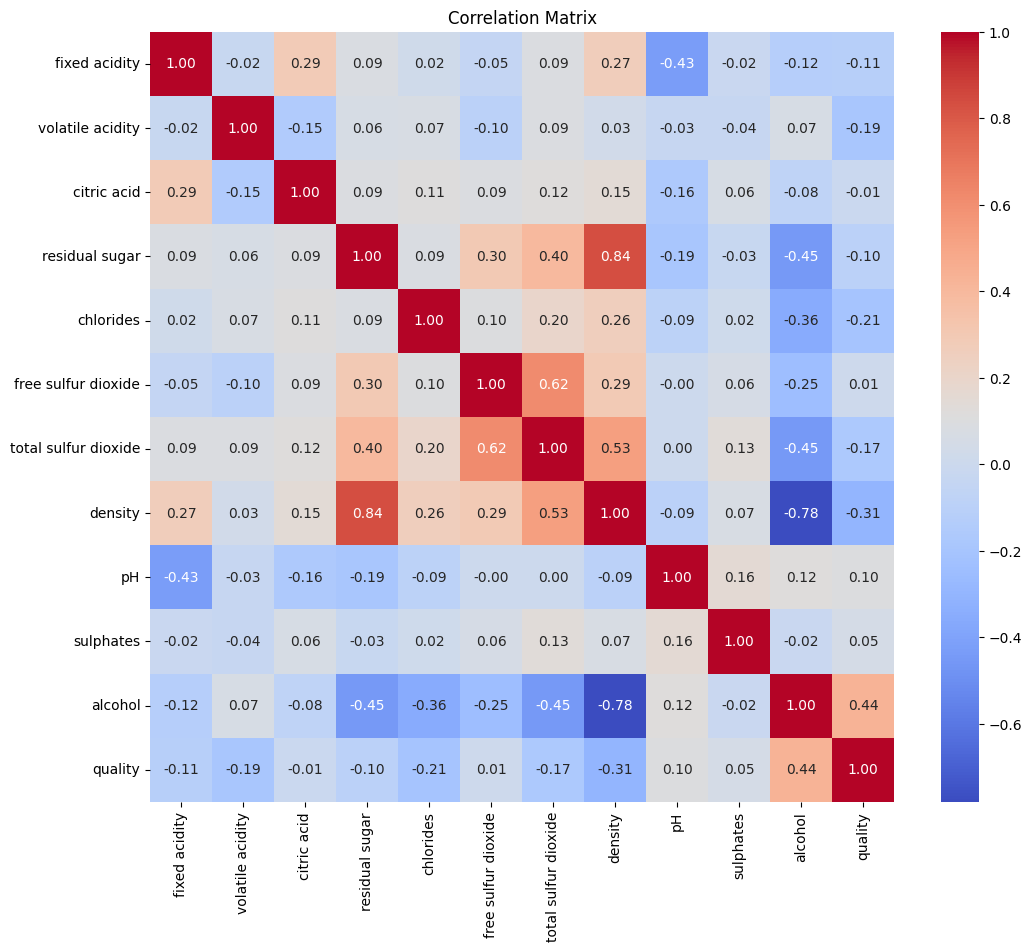

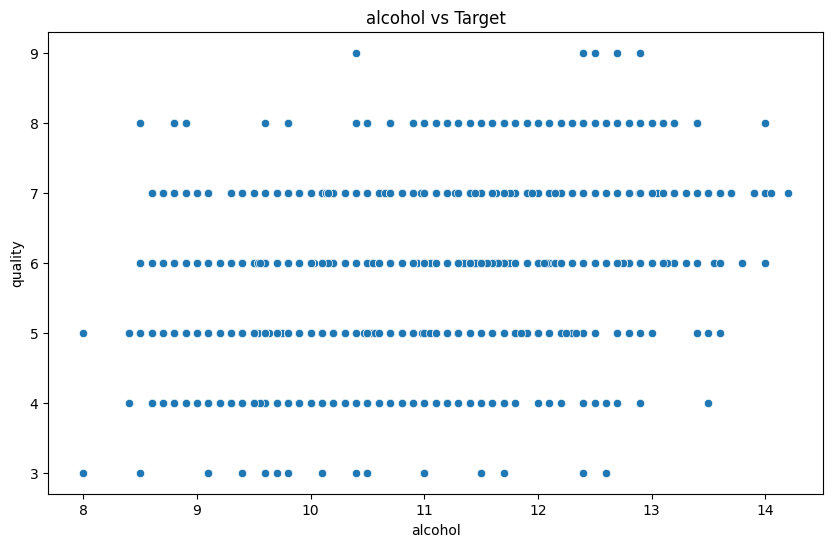

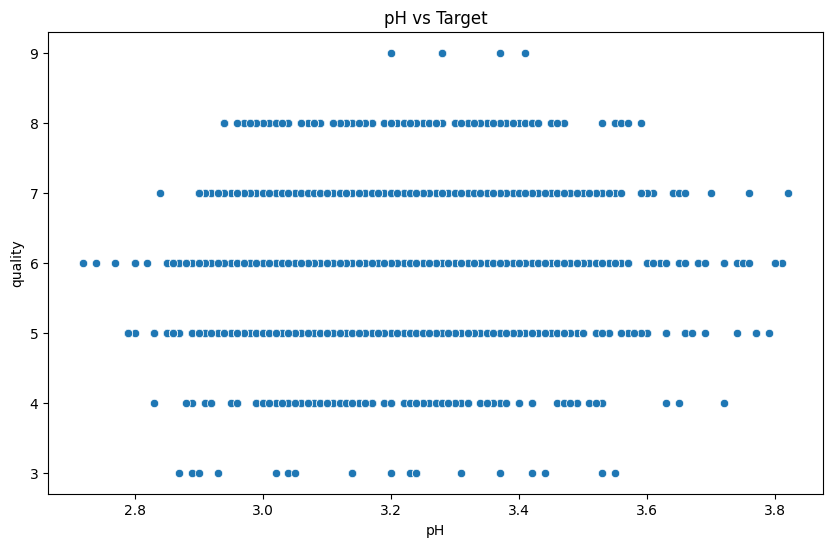

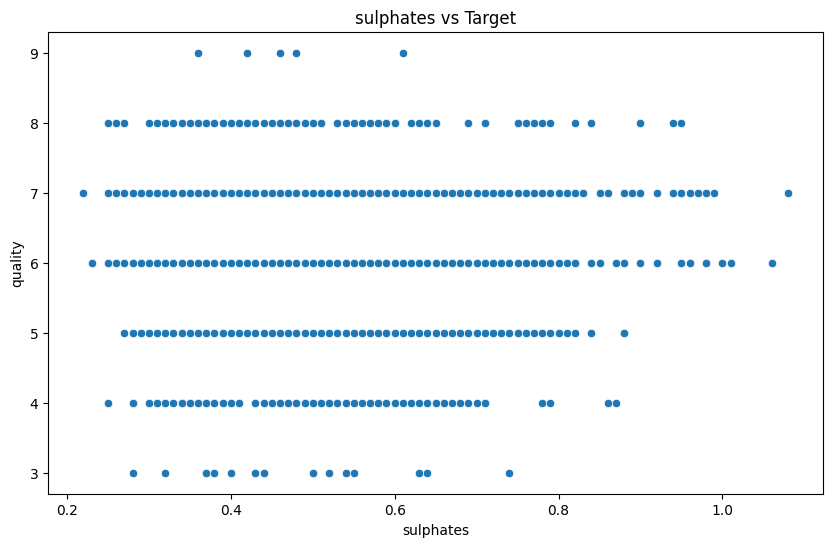

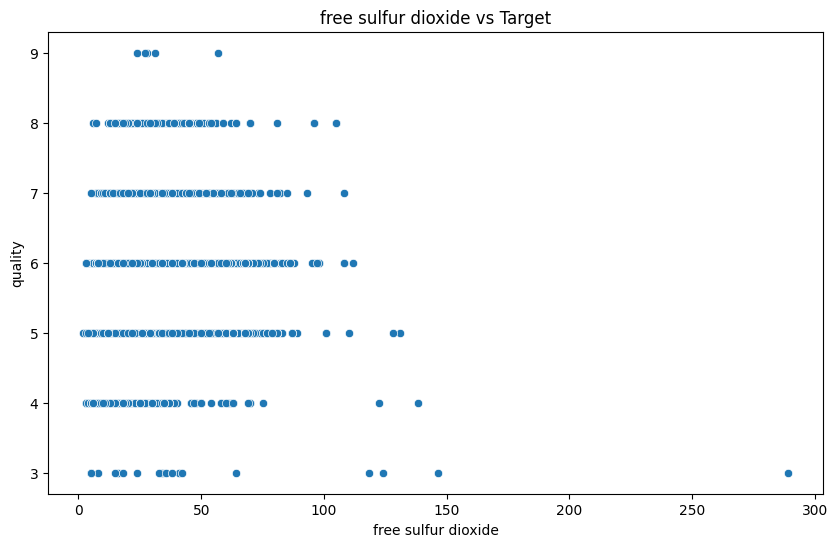

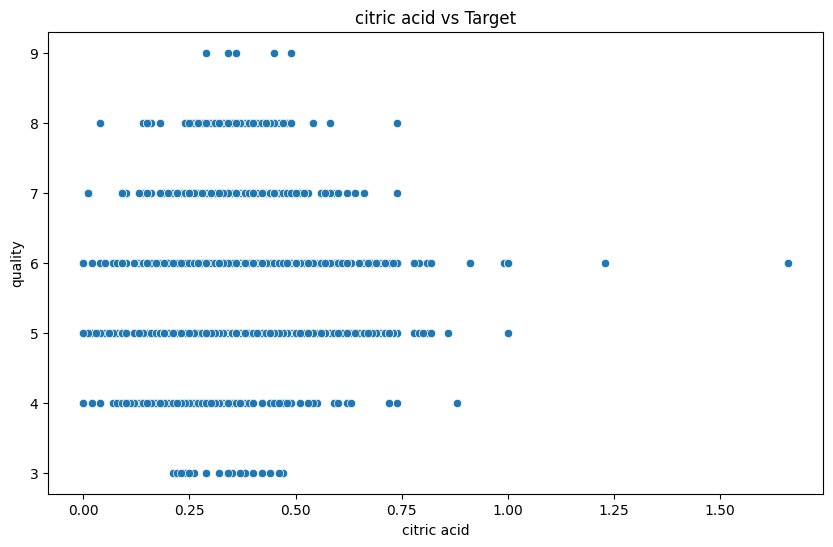

In [69]:
# Correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = df_white.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Scatter plots for top correlated features with target
top_corr_features = corr_matrix['quality'].sort_values(ascending=False).index[1:6]
for feature in top_corr_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature, y='quality', data=df_white)
    plt.title(f'{feature} vs Target')
    plt.show()

### Cap outlier

In [70]:
# Option: Winsorize/cap outliers
def cap_outliers(df):
    df_capped = df.copy()
    for col in df.columns:
        if col != "quality":
            q1, q99 = df[col].quantile(0.01), df[col].quantile(0.99)
            print(col, )
            df_capped[col] = df_capped[col].clip(lower=q1, upper=q99)
    return df_capped

In [71]:
df_white_capped = cap_outliers(df_white)

fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol


In [72]:
len(df_white_capped)

4898

### Log transform skewed features

In [73]:
# Check skewness
skewed_features = ['total sulfur dioxide', 'free sulfur dioxide', 'residual sugar']
for feature in skewed_features:
    df_white_capped[f'{feature}_log'] = np.log1p(df_white_capped[feature])  # log(1+x) avoids log(0) issues

In [74]:
df_white_capped.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'total sulfur dioxide_log',
       'free sulfur dioxide_log', 'residual sugar_log'],
      dtype='object')

In [75]:
features = ['fixed acidity', 'volatile acidity', 'citric acid',
       'chlorides', 'density',
       'pH', 'sulphates', 'alcohol', 'total sulfur dioxide_log',
       'free sulfur dioxide_log', 'residual sugar_log']
X = np.array(df_white_capped[features])
y = np.array(df_white_capped["quality"])

In [76]:
X.shape

(4898, 11)

In [77]:
y.shape

(4898,)

### Train-Val-Test split

In [78]:
from sklearn.model_selection import train_test_split

# First split: 80% train, 20% temp (which will be further split)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: Split the temp set into validation and test (50% each of the 20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Verify the split proportions
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X):.1%})")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X):.1%})")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X):.1%})")

Training set: 3918 samples (80.0%)
Validation set: 490 samples (10.0%)
Test set: 490 samples (10.0%)


### Scale the features

In [79]:
from sklearn.preprocessing import StandardScaler

# Standard scaling (z-score normalization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [80]:
X_test_scaled.dtype

dtype('float64')

In [81]:
X_train_scaled.shape

(3918, 11)

In [ ]:
y_val

array([7, 5, 7, 6, 6, 6, 6, 6, 6, 6, 7, 5, 6, 6, 5, 6, 7, 6, 5, 5, 7, 6,
       6, 5, 5, 5, 6, 8, 6, 5, 7, 5, 6, 6, 5, 5, 5, 4, 5, 5, 7, 6, 6, 7,
       6, 6, 5, 8, 5, 6, 5, 7, 5, 5, 7, 5, 7, 6, 6, 5, 6, 3, 5, 5, 5, 6,
       6, 6, 6, 6, 5, 7, 6, 6, 5, 5, 7, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5,
       5, 5, 6, 5, 5, 6, 5, 6, 6, 5, 5, 5, 6, 6, 6, 6, 5, 5, 5, 5, 6, 7,
       7, 5, 6, 5, 5, 6, 6, 6, 5, 7, 4, 5, 7, 6, 6, 5, 6, 6, 7, 6, 5, 7,
       6, 6, 5, 5, 5, 5, 7, 5, 6, 7, 5, 6, 5, 6, 5, 6, 7, 6, 6, 6, 6, 4,
       5, 7, 4, 6, 5, 5])

In [83]:
np.save('../data/wine+quality/X_train_white.npy', X_train)
np.save('../data/wine+quality/y_train_white.npy', y_train)
np.save('../data/wine+quality/X_val_white.npy', X_val)
np.save('../data/wine+quality/y_val_white.npy', y_val)
np.save('../data/wine+quality/X_test_white.npy', X_test)
np.save('../data/wine+quality/y_test_white.npy', y_test)

## Now lets train MLP for white wine

In [84]:
X_train = np.load('../data/wine+quality/X_train_white.npy')
y_train = np.load('../data/wine+quality/y_train_white.npy')
y_train = y_train.reshape((len(y_train), 1))
X_val = np.load('../data/wine+quality/X_val_white.npy')
y_val = np.load('../data/wine+quality/y_val_white.npy')
y_val = y_val.reshape((len(y_val), 1))
X_test = np.load('../data/wine+quality/X_test_white.npy')
y_test = np.load('../data/wine+quality/y_test_white.npy')
y_test = y_test.reshape((len(y_test), 1))

In [96]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=1) # for regression
model.get_params_count()

430

In [97]:
adam = Adam(lr=0.002, epsilon=1e-8, beta1=0.90, beta2=0.99)

In [98]:
train_losses, val_losses = train(model, X_train, y_train, X_val, y_val, optim=adam, loss_fn=mse_loss, n_epochs=1000, batch_size=128)

Epoch 10/1000, Train Loss: 0.342026, Val Loss: 0.339390
Epoch 20/1000, Train Loss: 0.311233, Val Loss: 0.321584
Epoch 30/1000, Train Loss: 0.290053, Val Loss: 0.294006
Epoch 40/1000, Train Loss: 0.281654, Val Loss: 0.296898
Epoch 50/1000, Train Loss: 0.279894, Val Loss: 0.272513
Epoch 60/1000, Train Loss: 0.272813, Val Loss: 0.269447
Epoch 70/1000, Train Loss: 0.270571, Val Loss: 0.264994
Epoch 80/1000, Train Loss: 0.266235, Val Loss: 0.262009
Epoch 90/1000, Train Loss: 0.264467, Val Loss: 0.261138
Epoch 100/1000, Train Loss: 0.263375, Val Loss: 0.259999
Epoch 110/1000, Train Loss: 0.263660, Val Loss: 0.259910
Epoch 120/1000, Train Loss: 0.261026, Val Loss: 0.259395
Epoch 130/1000, Train Loss: 0.259593, Val Loss: 0.256042
Epoch 140/1000, Train Loss: 0.257901, Val Loss: 0.254695
Epoch 150/1000, Train Loss: 0.262950, Val Loss: 0.256727
Epoch 160/1000, Train Loss: 0.256804, Val Loss: 0.254233
Epoch 170/1000, Train Loss: 0.256741, Val Loss: 0.251816
Epoch 180/1000, Train Loss: 0.254604, Va

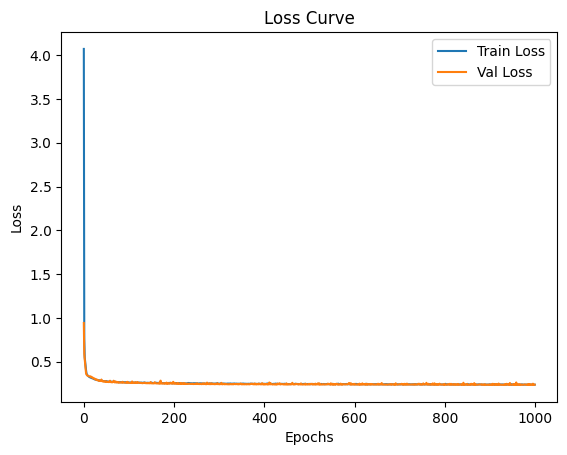

In [99]:
plot_loss(train_losses, val_losses)

In [100]:
# get the test loss
y_test_pred = model.forward(X_test)
test_loss, _ = mse_loss(y_test, y_test_pred)
print(test_loss)

0.265411021855933
